In [1]:
from nilearn.input_data import NiftiMasker, MultiNiftiMasker
from nilearn.datasets import fetch_atlas_basc_multiscale_2015
from fastsrm.fastsrm import FastSRM
from fastsrm import fastsrm
import matplotlib.pyplot as plt
from nilearn import image
from nilearn import plotting
import os
import glob
import numpy as np
from nilearn.image import new_img_like
import ibc_public
import nibabel as nib

%matplotlib inline

/home/sshankar/env/fastsrm/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Specify the mask image
_package_directory = os.path.dirname(os.path.abspath(ibc_public.__file__))
mask_gm = nib.load(os.path.join(_package_directory, '../ibc_data', 'gm_mask_3mm.nii.gz'))

In [4]:
# Do this for a previously unused atlas. 
# Else, you should have a .npy file saved from before, and you can just load it.
# The transform() funtion takes a few minutes to run so don't run it 
# unless you absolutely need to.

# Now, a bit of shape shifting to make the atlas compatible with
# what fastsrm.reduce_data() requires.
# 1. Add a 4th dimension to the 3D atlas. The 4th dimension will have as many
#   elements as atlas parcesl (444, in this case)
# 2. The 3D "volume" pertaining to each 4th dimension will contain 1 in the
#   "voxel" for that parcel and 0 otherwise
# 3. Apply the atlas masker set up previously to transform the new 4D atlas
#   into 2D, with n_voxel rows and n_parcel columns,
#   where n_voxel is the number of voxels in the transformed image matrix
# 4. Reduce the 2D atlas matrix to 1D by using the argmax function along the
#   column dimension. Now, the transformed atlas has n_voxel elements.

atlas_loc = os.path.join('..', task, '3mm')
if os.path.exists(os.path.join(atlas_loc, 'atlas_masked.npy')):
    atlas = np.load(os.path.join(atlas_loc, 'atlas_masked.npy'), allow_pickle=True)
else:
    # Specify the atlas
    basc444 = fetch_atlas_basc_multiscale_2015()['scale444']
    basc_im = image.load_img(basc444).get_data()

    atlas_masker = NiftiMasker(mask_img=mask_gm).fit()

    if len(basc_im.shape) == 3:
        n_components = len(np.unique(basc_im)) - 1
        xa, ya, za = basc_im.shape
        A = np.zeros((xa, ya, za, n_components + 1))
        atlas = np.zeros((xa, ya, za, n_components + 1))
        for c in np.unique(basc_im)[1:].astype(int):
            X_ = np.copy(basc_im)
            X_[X_ != c] = 0.
            X_[X_ == c] = 1.
            A[:, :, :, c] = X_
        atlas = atlas_masker.transform(new_img_like(basc444, A))
        atlas = np.argmax(atlas, axis=0)

    # # Save the transformed atlas
    np.save(os.path.join(atlas_loc, 'atlas_masked.npy'), atlas)

In [5]:
# Create a masker to standardize (0 mean, 1 SD) the image files
# and to transform them to a 2D array, as FastSRM requires
img_masker = NiftiMasker(mask_img=mask_gm, 
                              standardize=True, 
                              smoothing_fwhm=5,
                              detrend=True,
                              high_pass=1./128,
                              t_r=2.0).fit()

In [33]:
# Task of interest
task = 'raiders'

# Any specific files that should be used for FastSRM
if task == 'clips':
    filepattern = '*Trn*.nii.gz'
else:
    filepattern = '*.nii.gz'

In [34]:
# Now create a list of movie session files 
movie_dir = os.path.join('..', task, '3mm')
subs = sorted(os.listdir(movie_dir))
nsub = 0

movie_arrays = []

# Number of sessions per subject
# Different tasks have different numbers of sessions.
# Also, all subjects might not have completed all sessions.
if task == 'clips':
    # For the clips task, one subject doesn't have all 4 sessions, and
    # FastSRM requires that all subjects have the same numbers of TRs
    sessn = 3
else:
    sessn = 2

# Create 2D masked arrays from image data and save to file for quick and easy access
for s, sub in enumerate(subs):
    if os.path.isdir(os.path.join(movie_dir, sub)):
        nsub += 1
        sess = sorted(os.listdir(os.path.join(movie_dir, sub)))
        sidx = 0
       
        for i, ses in enumerate(sess):
            if os.path.isdir(os.path.join(movie_dir, sub, ses)) and sidx < sessn:
                sidx += 1
                if os.path.exists(os.path.join(movie_dir, sub, ses,'masked_imgs_preproc.npy')):
                    masked_imgs = np.load(os.path.join(movie_dir, sub, ses, 'masked_imgs_preproc.npy'), 
                                          allow_pickle=True)
                else:    
                    movie_imgs = sorted(glob.glob(os.path.join(movie_dir, sub, ses, filepattern)))
                    masked_imgs = img_masker.transform(movie_imgs)
                    np.save(os.path.join(movie_dir, sub, ses, 'masked_imgs_preproc.npy'), masked_imgs)

                movie_arrays.append(masked_imgs)

In [ ]:
for i in range(nsub):
    for j in range(len(movie_arrays[i])):
        print(movie_arrays[i][j].shape)
# movie_arrays[0][1].shape

In [37]:
len(movie_arrays[0])

6

In [38]:
# Concatenate all the runs belonging to each subject, 
# and then create a list of lists with all subjects' data
sub_movie = []
# nsess = len(movie_arrays[0])
for i in range(0, nsub*sessn, sessn):
    part = []
    for j in range(sessn):
        # The inner concatenates create one list each for each session
        # The outer concatenate creates one list with data from all runs
        part.append(np.concatenate(movie_arrays[i+j]))
    sub_movie.append(np.concatenate(part).T)
#         sub_movie.append(np.concatenate((np.concatenate(movie_arrays[i]), np.concatenate(movie_arrays[i+1]))).T)

In [39]:
for i in range(nsub):
    print(sub_movie[i].shape)

(46448, 3941)
(46448, 3941)
(46448, 3941)
(46448, 3941)
(46448, 3941)
(46448, 3941)
(46448, 3941)
(46448, 3941)
(46448, 3941)
(46448, 3941)


In [40]:
# Fit the FastSRM model with the trial data
fast_srm = FastSRM(
    atlas=atlas,
    n_components=20,
    n_jobs=1,
    n_iter=10,
    temp_dir='/tmp',
    low_ram=True, 
    aggregate="mean" 
)
fast_srm.fit(sub_movie)

FastSRM(aggregate='mean', atlas=array([333, 333, 190, ..., 112, 315, 315]),
        low_ram=True, n_components=20, n_iter=10, n_jobs=1, seed=None,
        temp_dir='/tmp/fastsrm5715fb1e-f791-4c60-b037-75746a319f30',
        verbose='warn')

In [41]:
# Compute the shared temporal responses of subjects while watching the movie
shared_resp = fast_srm.transform(sub_movie)

In [43]:
# Save the shared response vector for future use
np.save(os.path.join(movie_dir, 'shared_resp.npy'), shared_resp)

In [44]:
shared_resp.shape

(20, 3941)

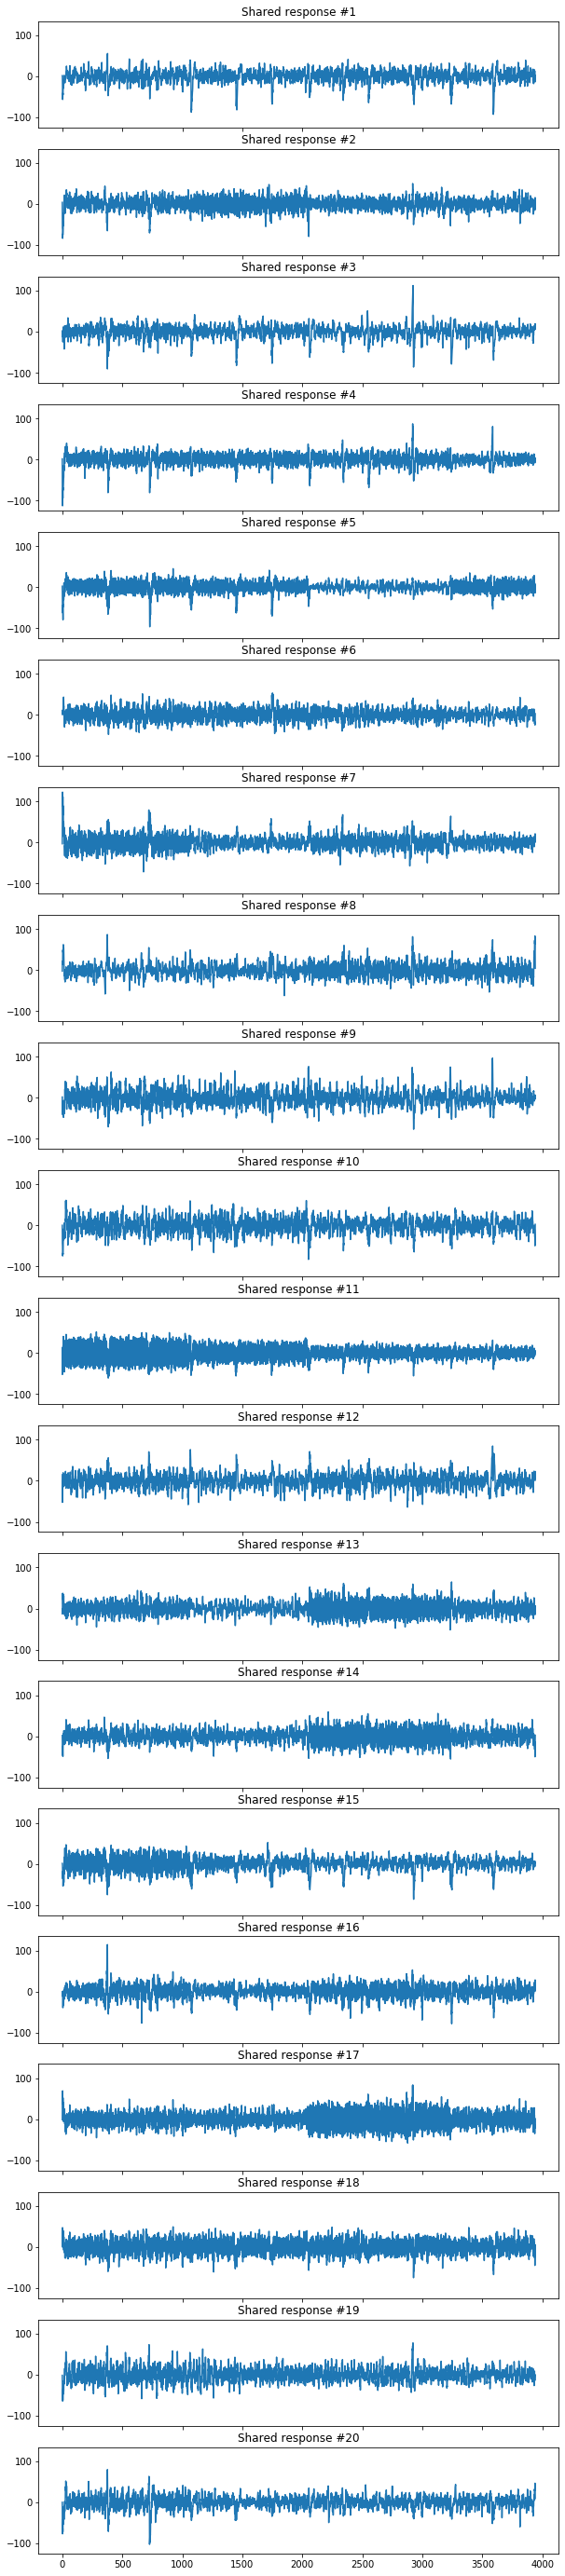

In [42]:
# These are what the shared responses look like
fig, axs = plt.subplots(20, sharex=True, sharey=True, 
                        figsize=(10,50))
# gridspec_kw={'hspace': 0.2}
for i in range(len(shared_resp)):
    axs[i].plot(shared_resp[i,:])
    axs[i].set_title('Shared response #' + str(i+1))
    

In [79]:
fig.savefig(os.path.join(movie_dir, 'shared_resp.pdf'), format='pdf', transparent=False)

In [49]:
bl1 = np.load('/tmp/fastsrmd4e3f775-93c7-41c1-b18a-06e23ada8ae7/basis_10.npy', allow_pickle=True)
bl1.shape

(20, 46448)

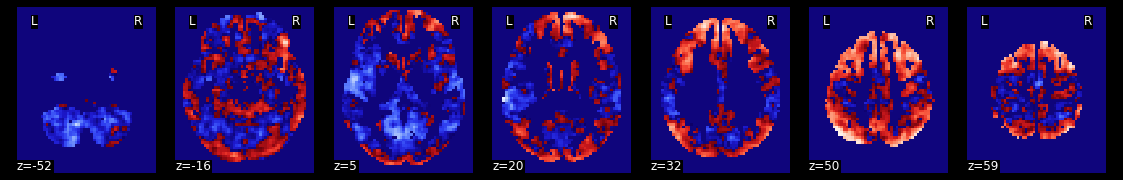

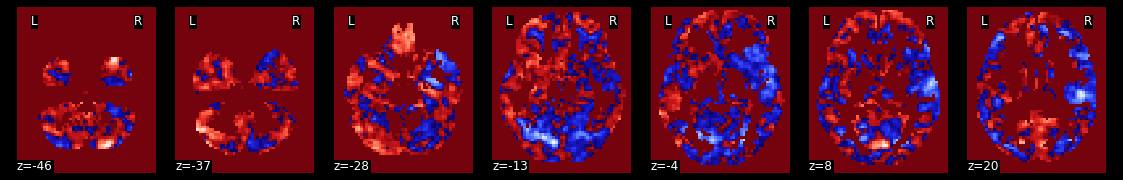

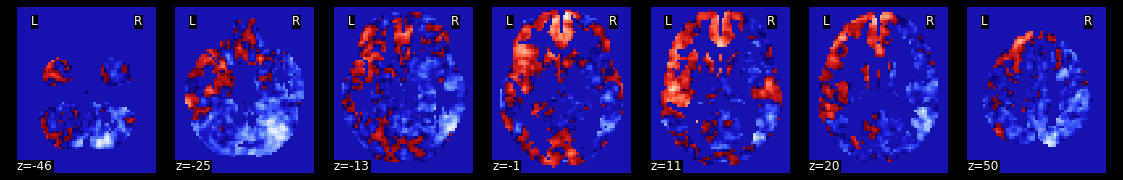

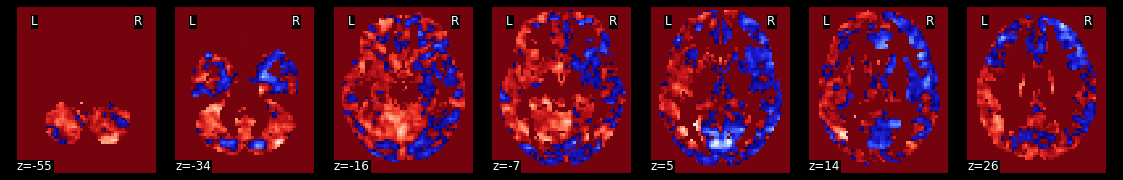

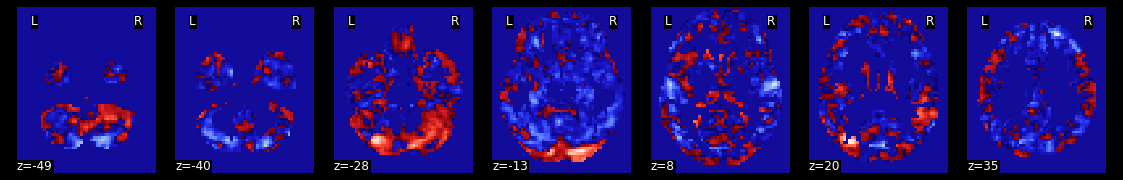

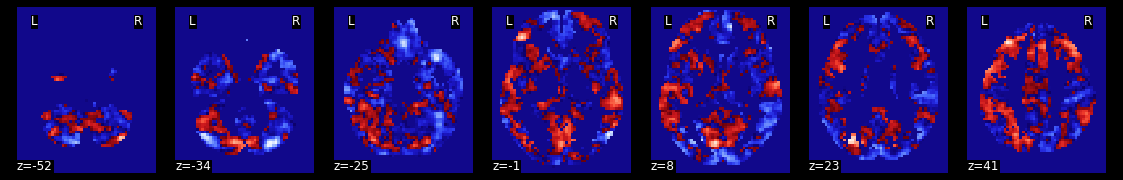

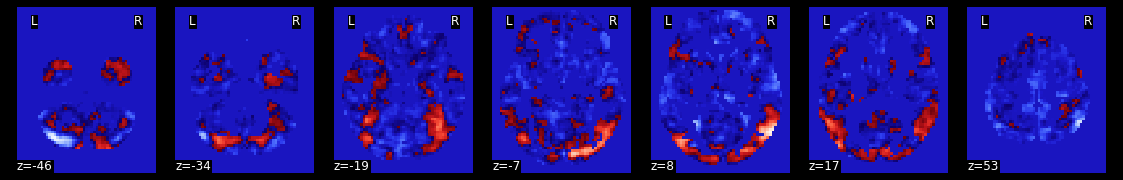

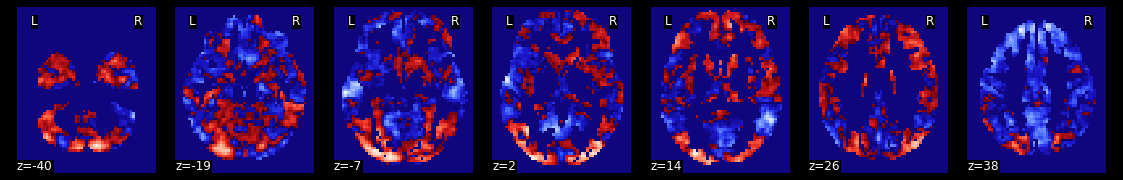

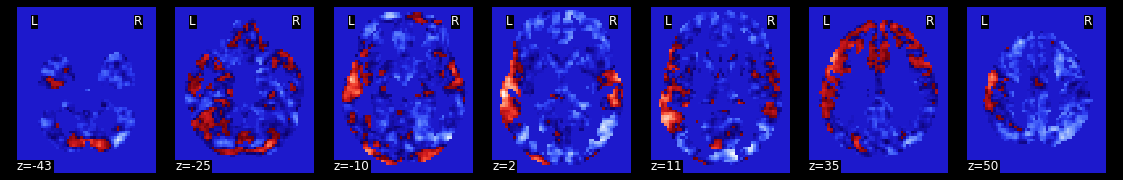

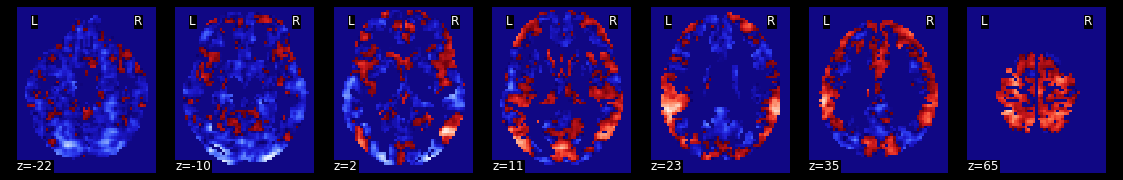

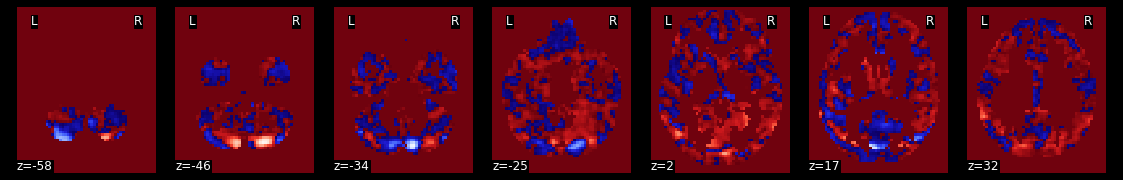

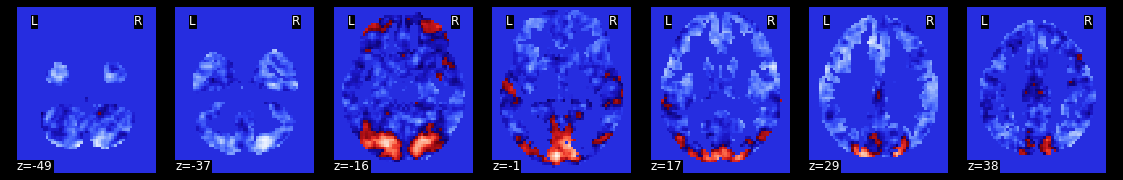

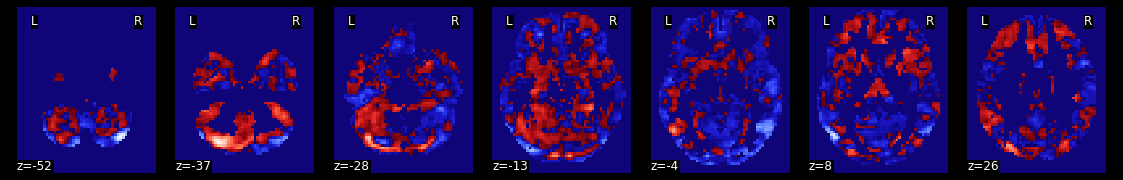

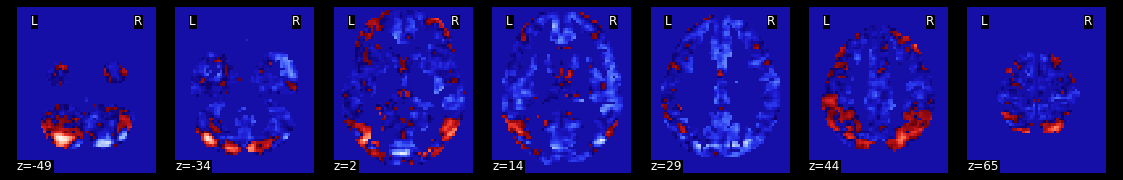

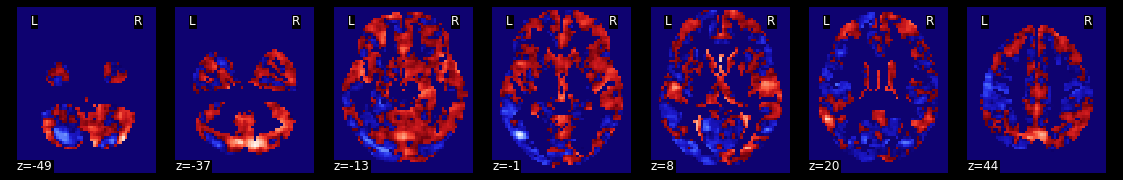

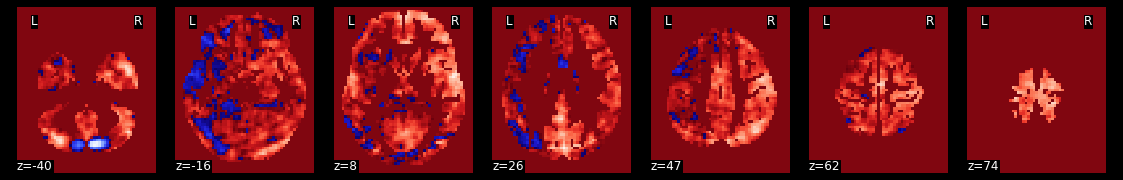

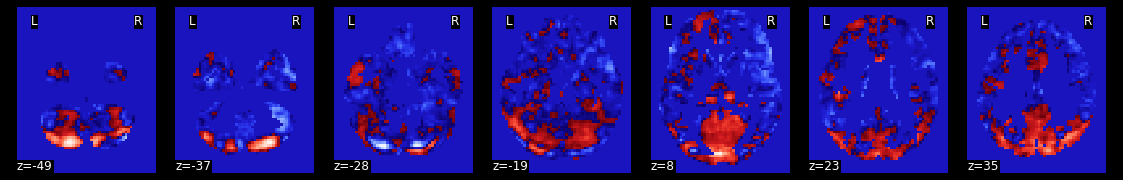

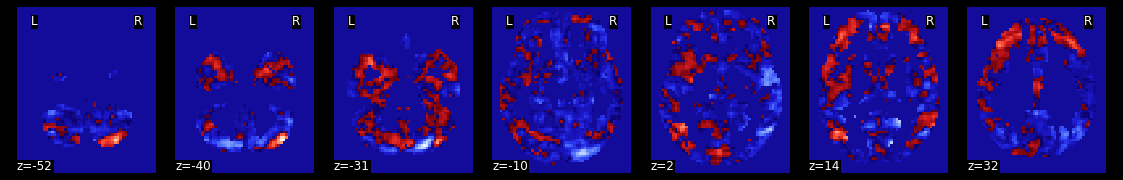

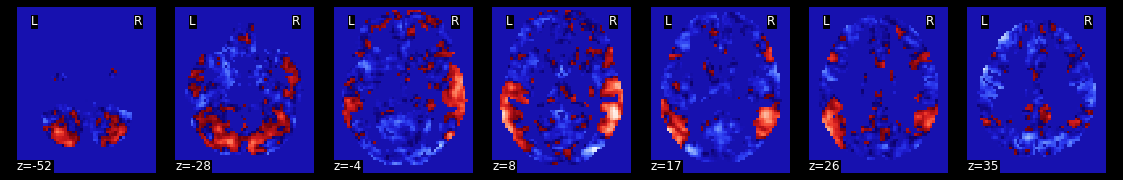

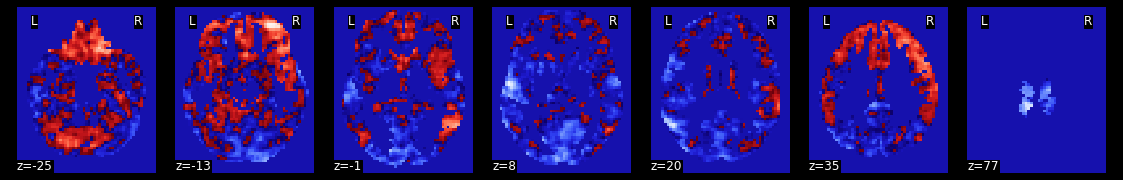

In [128]:
# These are what the spatial maps look like, for one subject
bl1 = np.load('/tmp/fastsrm774ad122-afb7-416b-a80e-ac571863c965/basis_9.npy', allow_pickle=True)
inv_mask_bl1 = img_masker.inverse_transform(bl1)

for i in range(len(shared_resp)):
    plotting.plot_epi(inv_mask_bl1.slicer[...,i], draw_cross=False, 
                     cut_coords=7, display_mode='z', black_bg=True, cmap=plotting.cm.blue_red)

In [41]:
# The subject-specific spatial maps are in the parameter basis_list
# These spatial maps have been created using all runs from all subjects
fast_srm.basis_list

['/tmp/fastsrm774ad122-afb7-416b-a80e-ac571863c965/basis_0.npy',
 '/tmp/fastsrm774ad122-afb7-416b-a80e-ac571863c965/basis_1.npy',
 '/tmp/fastsrm774ad122-afb7-416b-a80e-ac571863c965/basis_2.npy',
 '/tmp/fastsrm774ad122-afb7-416b-a80e-ac571863c965/basis_3.npy',
 '/tmp/fastsrm774ad122-afb7-416b-a80e-ac571863c965/basis_4.npy',
 '/tmp/fastsrm774ad122-afb7-416b-a80e-ac571863c965/basis_5.npy',
 '/tmp/fastsrm774ad122-afb7-416b-a80e-ac571863c965/basis_6.npy',
 '/tmp/fastsrm774ad122-afb7-416b-a80e-ac571863c965/basis_7.npy',
 '/tmp/fastsrm774ad122-afb7-416b-a80e-ac571863c965/basis_8.npy',
 '/tmp/fastsrm774ad122-afb7-416b-a80e-ac571863c965/basis_9.npy']

In [80]:
# Save the basis lists to subject folders for posterity
from shutil import copyfile
subs = os.listdir(movie_dir)
subs.sort()

sidx = 0
for s, sub in enumerate(subs):
    if os.path.isdir(os.path.join(movie_dir, sub)):
        copyfile(fast_srm.basis_list[sidx], os.path.join(movie_dir, sub, 'basis_list.npy'))
        sidx += 1

In [81]:
# Split the basis lists into their components and save them as 
# niimg-like files to use in other nistats/nilearn functions
subs = sorted(os.listdir(movie_dir))

sidx = 0
for s, sub in enumerate(subs):
    if os.path.isdir(os.path.join(movie_dir, sub)):
        bls = np.load(os.path.join(movie_dir, sub, 'basis_list.npy'))
        for i in range(20):
            nib.save(img_masker.inverse_transform(bls[i]), 
                     os.path.join(movie_dir, sub, 'basis_list-' + str(i) + '.nii.gz'))
        sidx += 1

In [ ]:
# On to second level model

In [82]:
# Import the necessary modules/functions
import pandas as pd
import numpy as np
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nilearn import plotting
from nistats.reporting import make_glm_report

In [85]:
# Let's gather the files that will form the input to the second level analysis
n_components = 20
second_level_input = np.empty((nsub,n_components), dtype='object')

sidx = 0
for s, sub in enumerate(subs):
    if os.path.isdir(os.path.join(movie_dir, sub)):
        for c in range(n_components):
            second_level_input[sidx][c] = os.path.join(movie_dir, sub, 'basis_list-' + str(c) + '.nii.gz')
        sidx += 1

In [86]:
# Construct a design matrix. We are including all subjects and 
# essentially finding the "main effects" of the contrasts performed
# in the first level analysis
design_matrix = pd.DataFrame([1] * len(second_level_input), columns=['intercept'])

In [87]:
# Set up the second level analysis
second_level_model = SecondLevelModel(smoothing_fwhm=8)

In [88]:
# Compute the contrast/main effect
for i in range(20):
    z_map = second_level_model.fit(list(second_level_input[:,i]), 
                                    design_matrix=design_matrix).compute_contrast(output_type='z_score')
    report = make_glm_report(second_level_model, 'intercept')
    report.save_as_html(os.path.join(movie_dir, 'component-' + str(i) + '.html'))

In [114]:
# Some FPR correction with cluster size thresholding, after applying an uncorrected p=0.01
thresholded_map1, threshold1 = map_threshold(z_map1, alpha=.01, height_control='fpr', cluster_threshold=0)

In [73]:
SecondLevelModel.fit?

In [98]:
second_level_input[:,0,...].shape

(10, 53, 63, 52)

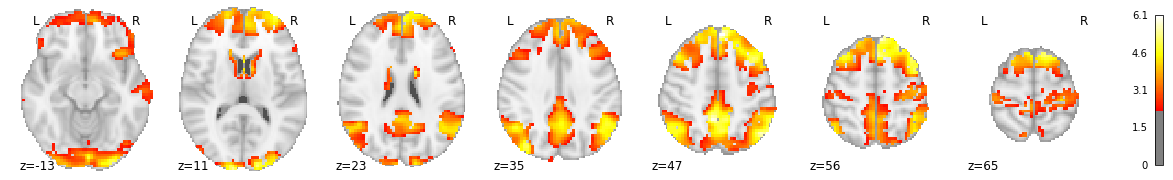

In [115]:
plotting.plot_stat_map(thresholded_map1, threshold=threshold1, display_mode='z')